# Predictive analytics for product segmentation in retail market using Deep Learning 

Segmentation is a technique used to identify and satisfy the needs of specific groups of customers with similar requirements within a market. Product segmentation provides a mechanism for a company to distribute the risk of selling a high-cost product across different target markets. Instead of having one product with one market and one supply-and-demand curve -- essentially putting all of the manufacturer's eggs in a single basket -- the manufacturer can sell sister models of the product at different prices to different market segments.

This notebook contains the analysis of data(over a period of one year (from 2010/12/01 to 2011/12/09) from a Retail online business store(E-commerce database) , using Deep Learning, in Python & Tensorflow using Keras. The data is available at : https://archive.ics.uci.edu/ml/datasets/Online+Retail

The task is to predict the category of the product to purchase based on various parameters.

Lets import the libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, warnings
warnings.filterwarnings("ignore")
from IPython.display import display, HTML
from sklearn import preprocessing, model_selection, metrics, feature_selection
%matplotlib inline

Now read the dataset

In [2]:
# read the datafile
df_read = pd.read_excel('OnlineRetail.xlsx',encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceNo': str})

Save a copy

In [3]:
df_initial= df_read

In [4]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     541909 non-null object
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


Observe that the dataset has 0.5 million entries. Due to resource limitaion, we extract a random of 50,000 entries from the datset

In [6]:
np.random.seed(1)
df_initial = df_initial.sample(frac=1).reset_index(drop=True)

In [7]:
df_initial= df_initial[:50000]

Now lets print the null value indices

In [8]:
# gives some infos on columns types and numer of null values
tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column dtype'})
tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index = {0:'null values'}))
tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column dtype,object,object,object,int64,datetime64[ns],float64,object,object
null values,0,0,132,0,0,0,0,0
null values (%),0,0,0.264,0,0,0,0,0


The column `Description` has 26.4 % of null values. Lets drop all of them from the model.

In [9]:
df_initial.dropna(axis = 0,inplace = True)
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49868 entries, 0 to 49999
Data columns (total 8 columns):
InvoiceNo      49868 non-null object
StockCode      49868 non-null object
Description    49868 non-null object
Quantity       49868 non-null int64
InvoiceDate    49868 non-null datetime64[ns]
UnitPrice      49868 non-null float64
CustomerID     49868 non-null object
Country        49868 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 3.4+ MB


In [10]:
# gives some infos on columns types and numer of null values
tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column dtype'})
tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index = {0:'null values'}))
tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column dtype,object,object,object,int64,datetime64[ns],float64,object,object
null values,0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0


Now that the null values are moved out, lets do the same with duplicates

In [11]:
print('Duplicate entries: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

Duplicate entries: 48


In [12]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49820 entries, 0 to 49999
Data columns (total 8 columns):
InvoiceNo      49820 non-null object
StockCode      49820 non-null object
Description    49820 non-null object
Quantity       49820 non-null int64
InvoiceDate    49820 non-null datetime64[ns]
UnitPrice      49820 non-null float64
CustomerID     49820 non-null object
Country        49820 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 3.4+ MB


## Feature Analysis

Lets now proceed to some feature analysis.

This dataframe contains 8 variables that correspond to:

**InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 

**StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. 

**Description**: Product (item) name. Nominal. 

**Quantity**: The quantities of each product (item) per transaction. Numeric. 

**InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated. 

**UnitPrice**: Unit price. Numeric, Product price per unit in sterling. 

**CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. 

**Country**: Country name. Nominal, the name of the country where each customer resides.

### 2.1 Countries
Here, Lets quickly look at the countries from which orders were made:

In [13]:
temp = df_initial.groupby(['Country'])
countries = temp['Country'].value_counts()
print('No. of countries in dataframe: {}'.format(len(countries)))

No. of countries in dataframe: 38


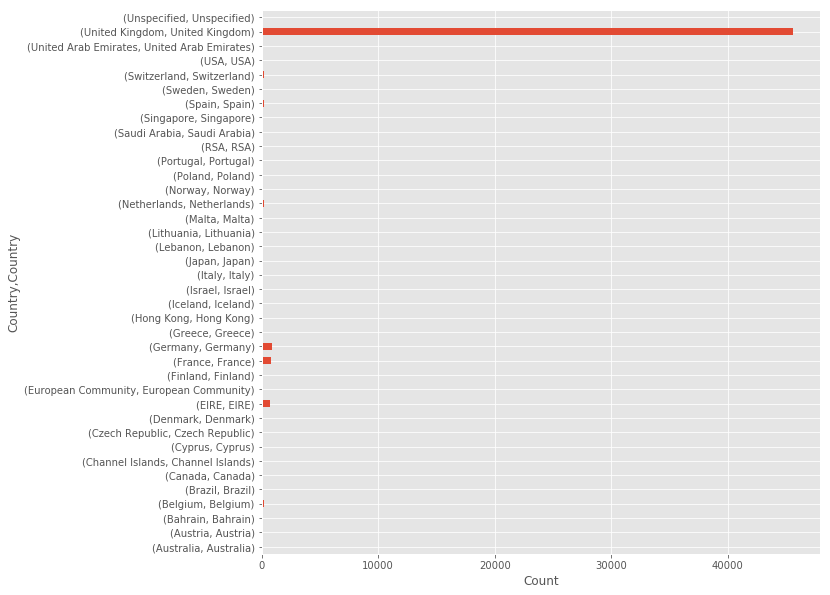

In [14]:
# Plot Countries
plt.style.use('ggplot')
plt.figure(figsize= (10,10))
plt.xlabel('Count')
temp['Country'].value_counts().plot(kind = 'barh', grid = True)
plt.show()

We see that the dataset is largely dominated by orders made from the UK. So lets create two categories UK and Non_UK

In [15]:
Country_n = []
for item in df_initial['Country']:
    if item == 'United Kingdom' :
        Country_n.append('UK')
    else:
        Country_n.append('Non_UK')
df_initial['Country_n'] = Country_n

### 2.2 Customers and orders

In [16]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3261,14253,3731


It can be seen that the data concern 3731 users and that they bought 3261 different products. The total number of transactions carried out is of the order of  ∼∼ 14253

#### Cancelling orders

First of all, count the number of transactions corresponding to canceled orders, indicated by the letter C in `InvoiceNo` feature.This creates another variable `OrderCancelled`

In [19]:
OrderCanceled = []
for item in df_initial['InvoiceNo']:
    if 'C' in str(item):
        OrderCanceled.append(1)
    else:
        OrderCanceled.append(0)
df_initial['OrderCancelled'] = OrderCanceled 

In [20]:
(df_initial['OrderCancelled'] == 1).sum()/(df_initial['InvoiceNo'].shape[0])

0.01718185467683661

We note that the number of cancellations is small, ($\sim$1.72% of the total number of transactions) as depicted in Figure.

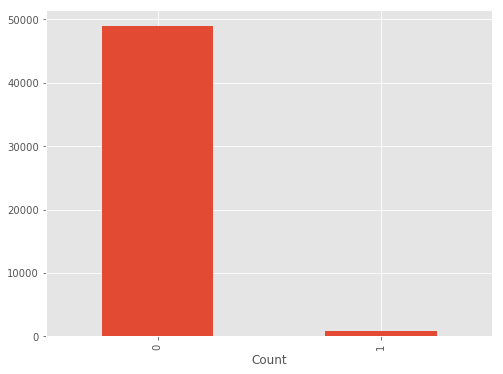

In [22]:
plt.figure(figsize= (8,6))
plt.xlabel('Count')
df_initial['OrderCancelled'].value_counts().plot(kind = 'bar', grid = True)
plt.show()

In [23]:
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_n,OrderCancelled
0,C544414,22960,JAM MAKING SET WITH JARS,-2,2011-02-18 14:54:00,3.75,13408,United Kingdom,UK,1
1,555276,48111,DOORMAT 3 SMILEY CATS,1,2011-06-01 17:28:00,15.79,nan,United Kingdom,UK,0
2,575656,22952,60 CAKE CASES VINTAGE CHRISTMAS,48,2011-11-10 14:29:00,0.55,13319,United Kingdom,UK,0
3,571636,20674,GREEN POLKADOT BOWL,16,2011-10-18 11:41:00,1.25,13509,United Kingdom,UK,0
4,576657,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-11-16 11:03:00,1.65,12720,Germany,Non_UK,0


### 2.3 InvoiceDate variable

Lets extract another variable, `Season_month` fro the `InvoiceDate` variable

In [25]:
df_initial['Season_month'] = df_initial['InvoiceDate'].map(lambda x: x.to_datetime().month)

In [26]:
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_n,OrderCancelled,Season_month
0,C544414,22960,JAM MAKING SET WITH JARS,-2,2011-02-18 14:54:00,3.75,13408,United Kingdom,UK,1,2
1,555276,48111,DOORMAT 3 SMILEY CATS,1,2011-06-01 17:28:00,15.79,nan,United Kingdom,UK,0,6
2,575656,22952,60 CAKE CASES VINTAGE CHRISTMAS,48,2011-11-10 14:29:00,0.55,13319,United Kingdom,UK,0,11
3,571636,20674,GREEN POLKADOT BOWL,16,2011-10-18 11:41:00,1.25,13509,United Kingdom,UK,0,10
4,576657,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-11-16 11:03:00,1.65,12720,Germany,Non_UK,0,11


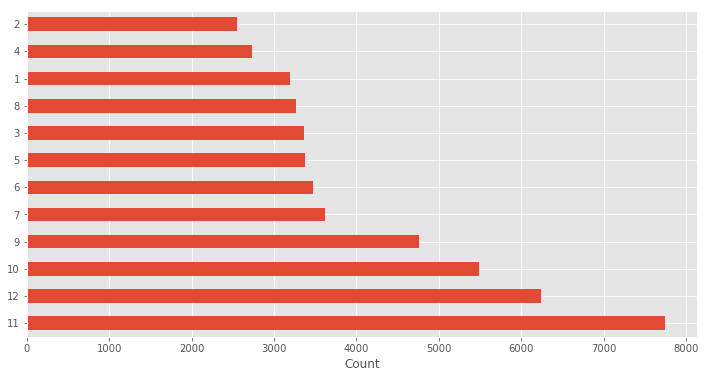

In [27]:
plt.figure(figsize= (12,6))
plt.xlabel('Count')
df_initial['Season_month'].value_counts().plot(kind = 'barh', grid = True)
plt.show()

Now create four Quarter categories and put them in the variable `Quarter_y`

In [30]:
Quarter = []
for item in df_initial['Season_month']:
    if item < 4 :
        Quarter.append('Q1')
    elif item < 7:
        Quarter.append('Q2')
    elif item < 10:
        Quarter.append('Q3')
    else:
        Quarter.append('Q4')

In [31]:
df_initial['Quarter_y'] = Quarter

### 2.3 Creating Product Category variable

Using the `StockCode` variable, lets create four product categories, counting the volume of sales.

In [33]:
Counts = df_initial['StockCode'].value_counts().to_dict()

In [34]:
Categ1 = [];Categ2 = [];Categ3 = [];Categ4 = []
for key,value in Counts.items():
    if value < 25:
        Categ4.append(str(key))
    elif value <= 50:
        Categ3.append(str(key))
    elif value <= 200:
        Categ2.append(str(key))
    else :
        Categ1.append(str(key))

In [35]:
Product_Categ = []
for item in df_initial['StockCode']: 
    if item in Categ1:
        Product_Categ.append(0)
    elif item in Categ2:
        Product_Categ.append(1)
    elif item in Categ3:
        Product_Categ.append(2)
    else:
        Product_Categ.append(3)

In [36]:
len(Product_Categ)

49820

Now add the variable to the DataFrame.

In [38]:
df_initial['Prod_Categ'] = Product_Categ

In [39]:
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_n,OrderCancelled,Season_month,Quarter_y,Prod_Categ
0,C544414,22960,JAM MAKING SET WITH JARS,-2,2011-02-18 14:54:00,3.75,13408,United Kingdom,UK,1,2,Q1,3
1,555276,48111,DOORMAT 3 SMILEY CATS,1,2011-06-01 17:28:00,15.79,nan,United Kingdom,UK,0,6,Q2,3
2,575656,22952,60 CAKE CASES VINTAGE CHRISTMAS,48,2011-11-10 14:29:00,0.55,13319,United Kingdom,UK,0,11,Q4,3
3,571636,20674,GREEN POLKADOT BOWL,16,2011-10-18 11:41:00,1.25,13509,United Kingdom,UK,0,10,Q4,3
4,576657,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-11-16 11:03:00,1.65,12720,Germany,Non_UK,0,11,Q4,3


### 2.3 Numerical variables

We have two numerical variables, `Quantity` and `UnitPrice`,

(-5000, 5000)

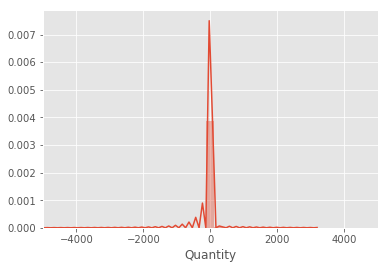

In [46]:
sns.distplot(df_initial["Quantity"])
plt.xlim(-5000,5000)

(0, 500)

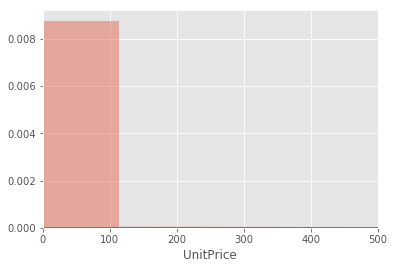

In [50]:
sns.distplot(df_initial["UnitPrice"])
plt.xlim(0,500)

In [48]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49820 entries, 0 to 49999
Data columns (total 13 columns):
InvoiceNo         49820 non-null object
StockCode         49820 non-null object
Description       49820 non-null object
Quantity          49820 non-null int64
InvoiceDate       49820 non-null datetime64[ns]
UnitPrice         49820 non-null float64
CustomerID        49820 non-null object
Country           49820 non-null object
Country_n         49820 non-null object
OrderCancelled    49820 non-null int64
Season_month      49820 non-null int64
Quarter_y         49820 non-null object
Prod_Categ        49820 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4), object(7)
memory usage: 5.3+ MB


The DataFrame is ready. Lets now create X and y variables.

In [52]:
X = df_initial.drop(['InvoiceNo','StockCode','Description','InvoiceDate','CustomerID','Country','Season_month','Prod_Categ'], axis = 1)
y = df_initial['Prod_Categ']

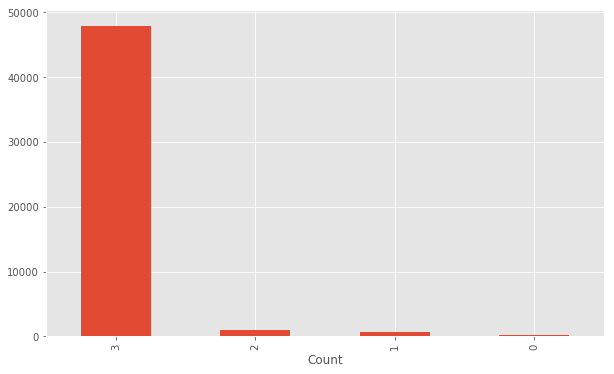

In [55]:
plt.figure(figsize= (10,6))
plt.xlabel('Count')
y.value_counts().plot(kind = 'bar', grid = True)
plt.show()

The output variable is highly skewed. This might call for normalization in the training stage

Encode categorical variables

In [58]:
categorical = ['OrderCancelled','Quarter_y', 'Country_n']
categorical_variables = categorical
X = pd.get_dummies(X, columns = categorical_variables)

In [ ]:
#label encoder
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)

Now proceed to Feature scaling

In [60]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

Create train and test sets

In [61]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Deep Learning

Import TensorFlow and Keras

In [62]:
import tensorflow as tf
from keras.utils import np_utils
tf.logging.set_verbosity(tf.logging.INFO)

Using TensorFlow backend.


Encode y_train and y_test using `to_categorical` in `np.utils`

In [63]:
from sklearn.preprocessing import LabelEncoder
def encode_neural_net_y(y):
    encoder = LabelEncoder()
    encoder.fit(y)
    encoded_y = encoder.transform(y)
    new_y = np_utils.to_categorical(encoded_y)
    return new_y
# Encoding y_train and y_test
y_train = encode_neural_net_y(y_train)
y_test = encode_neural_net_y(y_test)

In [64]:
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (39856, 10)
Shape of y_train:  (39856, 4)
Shape of X_test:  (9964, 10)
Shape of y_test:  (9964, 4)


In [65]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.normalization import BatchNormalization

# create model
model = Sequential()
model.add(Dense(35, input_dim=10, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(4, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

The layers are created using `kers.layers`. We build 2-layer fully connected neural network with 35 neurons in hidden layer. 

Batch normalization layer is inserted between hidden layer and output layer. This can take into account the skewness in the data.

The `categorical_crossentropy` is used as loss function and updating method/ optimizer is `ADAM`. Activation for the input layers is `relu` and that for the ouput layer is `softmax`

In [66]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 35)                385       
_________________________________________________________________
batch_normalization_1 (Batch (None, 35)                140       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 144       
Total params: 669
Trainable params: 599
Non-trainable params: 70
_________________________________________________________________


Now train the model to predict the Product Categories from the transaction data

In [67]:
history = model.fit(np.array(X_train), np.array(y_train), epochs=30, batch_size=40, verbose=1)

Epoch 1/30
39856/39856 [==============================] - 4s 111us/step - loss: 0.3439 - acc: 0.9264
Epoch 2/30
39856/39856 [==============================] - 4s 99us/step - loss: 0.1932 - acc: 0.9632
Epoch 3/30
39856/39856 [==============================] - 4s 94us/step - loss: 0.1929 - acc: 0.9633
Epoch 4/30
39856/39856 [==============================] - 4s 99us/step - loss: 0.1924 - acc: 0.9632
Epoch 5/30
39856/39856 [==============================] - 4s 102us/step - loss: 0.1917 - acc: 0.9633
Epoch 6/30
39856/39856 [==============================] - 4s 108us/step - loss: 0.1923 - acc: 0.9632
Epoch 7/30
39856/39856 [==============================] - 4s 106us/step - loss: 0.1907 - acc: 0.9633
Epoch 8/30
39856/39856 [==============================] - 4s 97us/step - loss: 0.1906 - acc: 0.9634
Epoch 9/30
39856/39856 [==============================] - 4s 93us/step - loss: 0.1907 - acc: 0.9633
Epoch 10/30
39856/39856 [==============================] - 4s 99us/step - loss: 0.1905 - acc: 0.

In [68]:
scores = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
print("====================[TEST SCORE]====================")
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

====================[TEST SCORE]====================
acc: 96.32%


In [69]:
scores = model.evaluate(np.array(X_train), np.array(y_train), verbose=0)
print("====================[TRAIN SCORE]====================")
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

====================[TRAIN SCORE]====================
acc: 96.35%


# Concluding Remarks

1. The model has a farily good performance on the train as well as on the test sets. Features are analysed and new features have been created to help with the predictions.
2. The test set accuracy is lower than the train set accuarcy by only a negligible percentage, yet the effect of regularization is to be studied
3. Another dimension to the feature engineering can be extracing the product information from the `Description` variable, using Natural Language Processing libraries like `nltk`.